<a href="https://colab.research.google.com/github/cherry1601/cnn-filter-size-kernel-init-analysis/blob/main/kernal_filter_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow seaborn --quiet

import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize and reshape (CNN needs HxWxC)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# One-hot labels
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat  = keras.utils.to_categorical(y_test, 10)


In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 6
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.15

FILTER_SIZES = [1, 3, 5]

INITIALIZERS = {
    "glorot_uniform": keras.initializers.GlorotUniform(),
    "he_normal": keras.initializers.HeNormal()
}

RESULTS_DIR = "cnn_results"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [ ]:
def build_cnn(filter_size, kernel_init):
    model = keras.Sequential([
        keras.Input(shape=(28, 28, 1)),

        layers.Conv2D(32, (filter_size, filter_size), activation="relu", kernel_initializer=kernel_init),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (filter_size, filter_size), activation="relu", kernel_initializer=kernel_init),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation="relu", kernel_initializer=kernel_init),

        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
x_train_main, x_val, y_train_main_cat, y_val_cat, y_train_main_raw, y_val_raw = train_test_split(
    x_train, y_train_cat, y_train,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=y_train
)


In [ ]:
results = {}

for filt in FILTER_SIZES:
    for init_name, init_val in INITIALIZERS.items():

        config_name = f"f{filt}_init_{init_name}"
        print("\n" + "="*70)
        print(f"Training config: {config_name}")
        print("="*70)

        model = build_cnn(filter_size=filt, kernel_init=init_val)

        val_callback = ValMetricsCallback(validation_data=(x_val, y_val_cat, y_val_raw))
        ckpt_path = os.path.join(RESULTS_DIR, f"{config_name}.keras")

        checkpoint = ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy")
        earlystop = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)

        history = model.fit(
            x_train_main, y_train_main_cat,
            validation_data=(x_val, y_val_cat),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[val_callback, checkpoint, earlystop],
            verbose=2
        )

        # TEST SET EVALUATION
        test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
        y_pred_prob = model.predict(x_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        test_prec = precision_score(y_test, y_pred, average="macro")
        test_rec  = recall_score(y_test, y_pred, average="macro")
        confmat = confusion_matrix(y_test, y_pred)

        # Store results
        results[config_name] = {
            "history": history.history,
            "val_precision": val_callback.val_precisions,
            "val_recall": val_callback.val_recalls,
            "test_accuracy": test_acc,
            "test_precision": test_prec,
            "test_recall": test_rec,
            "confusion_matrix": confmat
        }

        # Save report file
        with open(os.path.join(RESULTS_DIR, f"{config_name}_report.txt"), "w") as f:
            f.write(f"Filter Size: {filt}\nInitializer: {init_name}\n")
            f.write(f"Test Accuracy: {test_acc:.4f}\n")
            f.write(f"Test Precision: {test_prec:.4f}\n")
            f.write(f"Test Recall: {test_rec:.4f}\n")
            f.write("\nClassification Report:\n")
            f.write(classification_report(y_test, y_pred))



Training config: f1_init_glorot_uniform
Epoch 1/6
 — val_precision: 0.2529 — val_recall: 0.3071
797/797 - 38s - 47ms/step - accuracy: 0.2469 - loss: 1.9515 - val_accuracy: 0.3071 - val_loss: 1.7988 - val_precision: 0.2529 - val_recall: 0.3071
Epoch 2/6
 — val_precision: 0.3292 — val_recall: 0.3552
797/797 - 26s - 33ms/step - accuracy: 0.3350 - loss: 1.7333 - val_accuracy: 0.3552 - val_loss: 1.7005 - val_precision: 0.3292 - val_recall: 0.3552
Epoch 3/6
 — val_precision: 0.3486 — val_recall: 0.3712
797/797 - 37s - 47ms/step - accuracy: 0.3571 - loss: 1.6803 - val_accuracy: 0.3712 - val_loss: 1.6637 - val_precision: 0.3486 - val_recall: 0.3712
Epoch 4/6
 — val_precision: 0.3573 — val_recall: 0.3890
797/797 - 41s - 52ms/step - accuracy: 0.3797 - loss: 1.6461 - val_accuracy: 0.3890 - val_loss: 1.6257 - val_precision: 0.3573 - val_recall: 0.3890
Epoch 5/6
 — val_precision: 0.4157 — val_recall: 0.4070
797/797 - 41s - 52ms/step - accuracy: 0.4004 - loss: 1.6076 - val_accuracy: 0.4070 - val_lo

KeyboardInterrupt: 

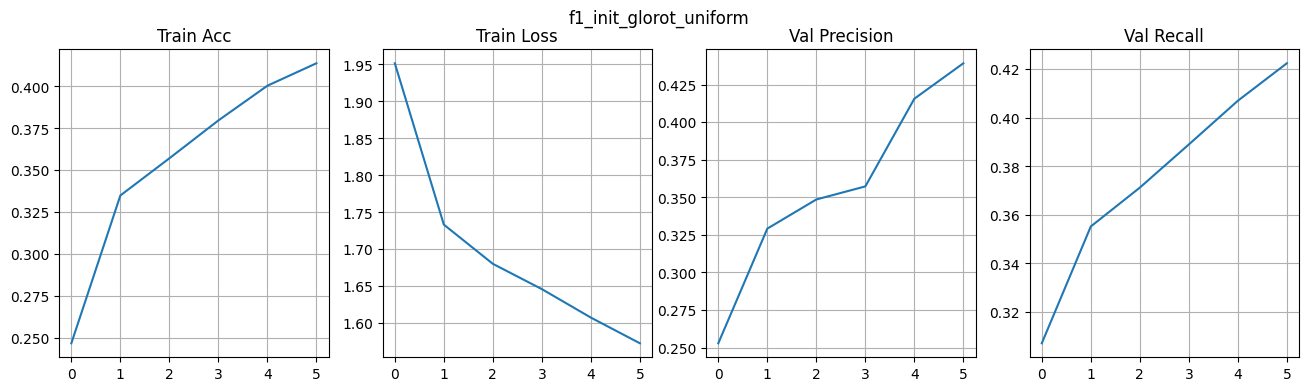

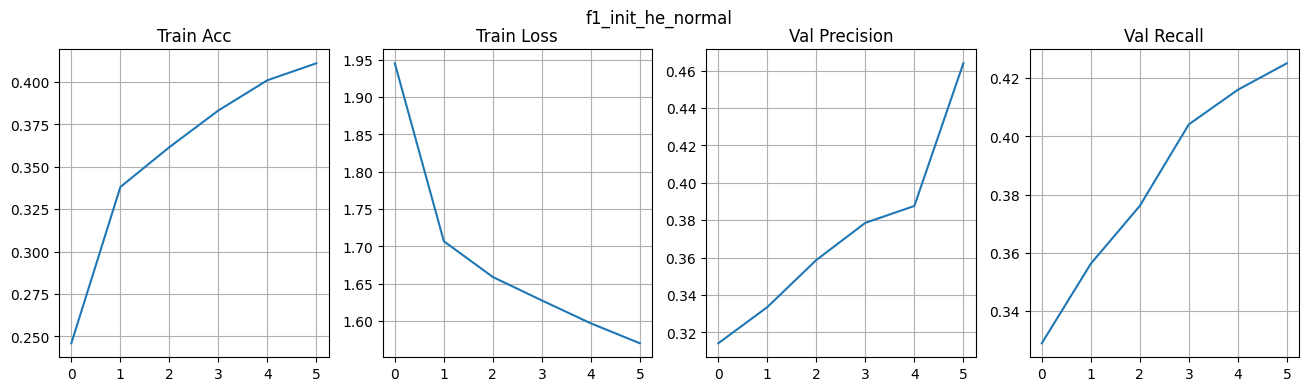

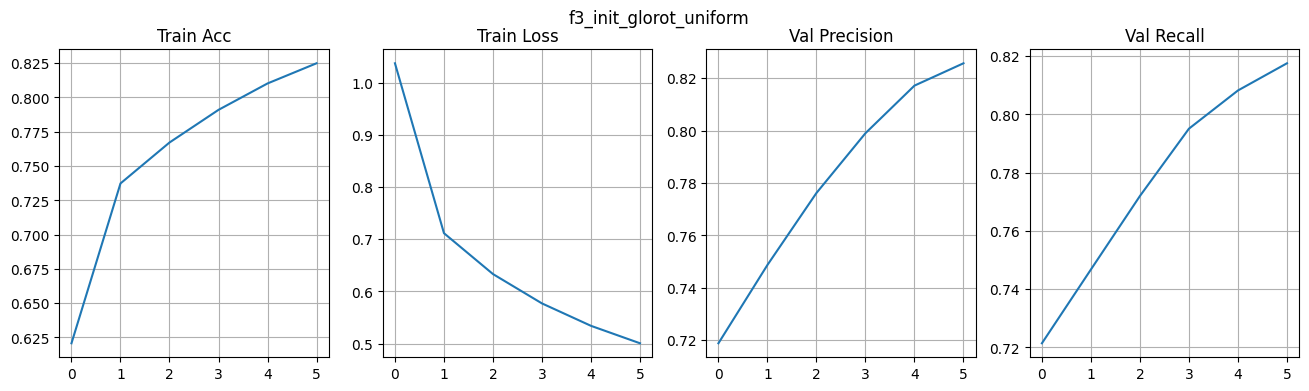

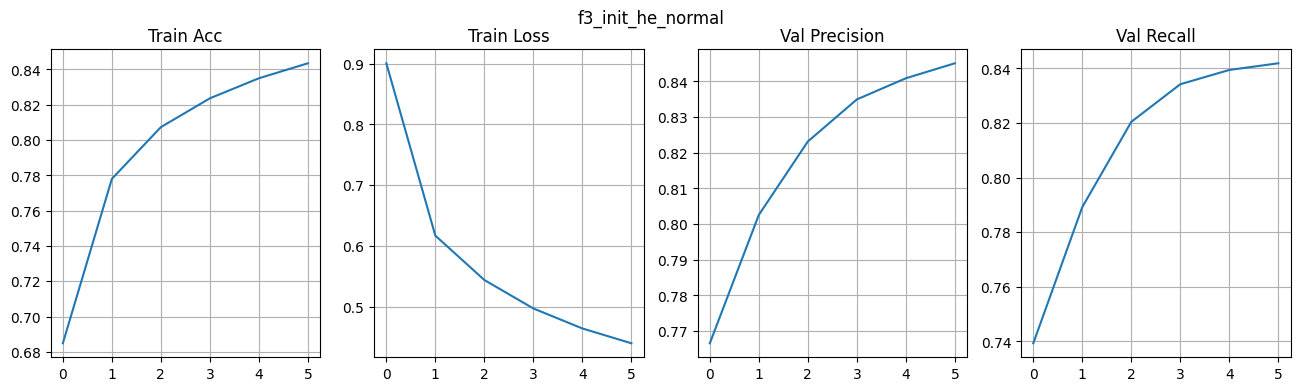

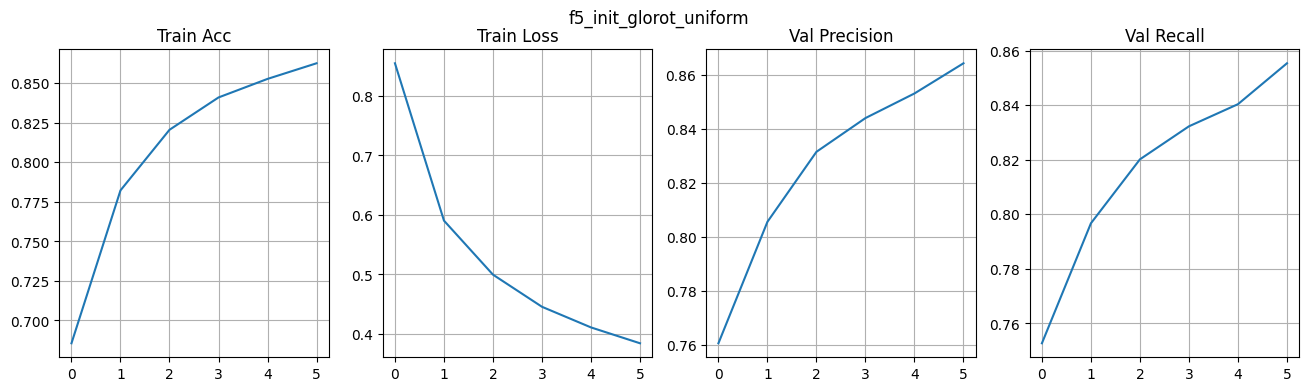

In [ ]:
def plot_curves(history, val_prec, val_rec, title):
    plt.figure(figsize=(16,4))

    # Accuracy
    plt.subplot(1,4,1)
    plt.plot(history["accuracy"]); plt.title("Train Acc"); plt.grid()

    # Loss
    plt.subplot(1,4,2)
    plt.plot(history["loss"]); plt.title("Train Loss"); plt.grid()

    # Precision
    plt.subplot(1,4,3)
    plt.plot(val_prec); plt.title("Val Precision"); plt.grid()

    # Recall
    plt.subplot(1,4,4)
    plt.plot(val_rec); plt.title("Val Recall"); plt.grid()

    plt.suptitle(title)
    plt.show()

for name, r in results.items():
    plot_curves(r["history"], r["val_precision"], r["val_recall"], name)


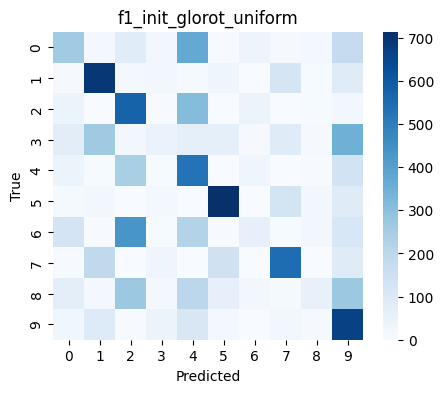

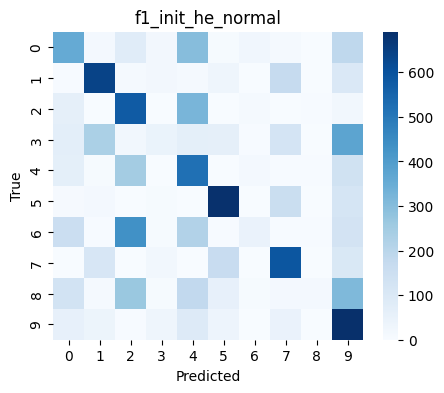

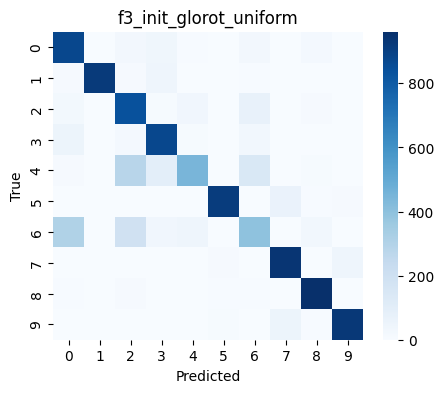

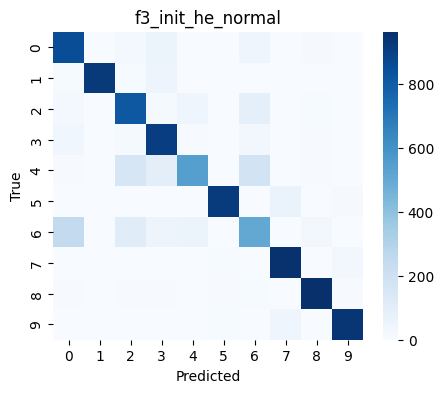

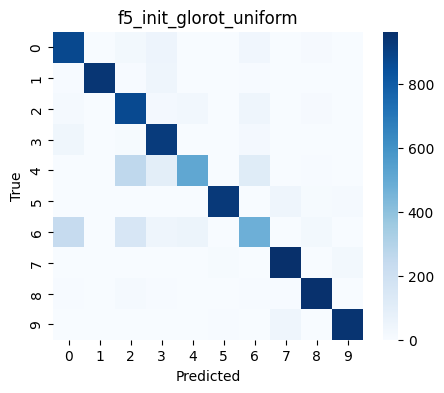

In [ ]:
def plot_confmat(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

for name, r in results.items():
    plot_confmat(r["confusion_matrix"], name)
